In [2]:
import numpy as np
import pandas as pd
import pickle
import requests
from timeit import default_timer as timer
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [3]:
movies = pickle.load(open("../pickle/movies.pkl", "rb"))
cosine = pickle.load(open("../pickle/cosine_sim.pkl", "rb"))
knn_similarity = pickle.load(open("../pickle/knn.pkl", "rb"))
lsa = pickle.load(open("../pickle/lsa.pkl", "rb"))

In [4]:
def recommendMovieCosine(selected_movies):
    start = timer()

    # Find the index of the movie that matches the title
    index = movies[movies["Series_Title"] == selected_movies].index[0]
    distance = sorted(list(enumerate(cosine[index])), reverse=True, key=lambda vector: vector[1])

    end = timer()

    time_executed = (end - start) * 1000
    return time_executed


In [5]:
def recommendMovieKNN(selected_movies):

    # Start the timer
    start = timer()

    index = movies[movies["Series_Title"] == selected_movies].index[0]
    
    # Reduce the dimensionality of the input movie (same transformation as training)
    pca = PCA(n_components=1000)  # Use the number of components you want
    similarity_reduced = pca.fit_transform(knn_similarity)  # Apply PCA to reduce dimensionality
    movie_reduced = pca.transform(knn_similarity[index].reshape(1, -1))
    
    # Perform the k-nearest neighbors search
    knn = NearestNeighbors(metric="cosine", algorithm="brute", n_neighbors=20)
    knn.fit(similarity_reduced)
    distances, indices = knn.kneighbors(movie_reduced, n_neighbors=5)
    indices = indices.flatten()  # Flatten the indices to use for Pandas indexing

    end = timer()

    time_executed = (end - start) * 1000
    return time_executed

In [6]:
# LSA
def euclidean_distance(vec1, vec2):
    return np.sqrt(np.sum((vec1 - vec2) ** 2))

def find_similar_movies(target_vec, lsa):
    distances = []
    for idx, movie_vec in enumerate(lsa):
        diff = euclidean_distance(target_vec, movie_vec)
        distances.append((idx, diff))
    
    # Sort distances in ascending order
    distances.sort(key=lambda x: x[1])
    
    # Return similar movies
    return distances[:10]

def recommendMovieLSA(selected_movies):
    start = timer()

    # Find the index of the movie that matches the title
    index = movies[movies["Series_Title"] == selected_movies].index[0]

    # Perform similarity search on the full dataset
    target_vec = lsa[index]
    similar_movies = find_similar_movies(target_vec, lsa)

    end = timer()

    time_executed = (end - start) * 1000
    return time_executed

In [7]:
all_movies = movies["Series_Title"].to_list()

print(all_movies[0])
print(len(all_movies))

The Shawshank Redemption
1000


In [8]:
movies.head()

,Series_Title,Poster_Link
0,The Shawshank Redemption,https://m.media-amazon.com/images/M/MV5BMDFkYT...
1,The Godfather,https://m.media-amazon.com/images/M/MV5BM2MyNj...
2,The Dark Knight,https://m.media-amazon.com/images/M/MV5BMTMxNT...
3,The Godfather: Part II,https://m.media-amazon.com/images/M/MV5BMWMwMG...
4,12 Angry Men,https://m.media-amazon.com/images/M/MV5BMWU4N2...


In [9]:
# calculate every movies recommended time using cosine similarity algorithm
cosine_times = []
for i in all_movies:
    cosine_time = recommendMovieCosine(i)
    cosine_times.append(cosine_time)

print(cosine_times[0])
print(len(cosine_times))

1.788900000974536
1000


In [10]:
# calculate every movies recommended time using KNN algorithm
knn_times = []
for i in all_movies:
    knn_time = recommendMovieKNN(i)
    knn_times.append(knn_time)

print(knn_times[0])
print(len(knn_times))

354.99399999389425
1000


In [11]:
# calculate every movies recommended time using LSA algorithm
lsa_times = []
for i in all_movies:
    lsa_time = recommendMovieLSA(i)
    lsa_times.append(lsa_time)

print(lsa_times[0])
print(len(lsa_times))

12.924499984364957
1000


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
# Create a DataFrame to organize the data
data = pd.DataFrame({
    "Movies": all_movies,
    "Cosine Similarity": cosine_times,
    "KNN": knn_times,
    "LSA": lsa_times
})

In [14]:
data.head()

,Movies,Cosine Similarity,KNN,LSA
0,The Shawshank Redemption,1.7889,354.9940,12.9245
1,The Godfather,2.4834,281.7906,10.8007
2,The Dark Knight,0.8791,265.7451,10.8062
3,The Godfather: Part II,0.9923,310.9008,9.8326
4,12 Angry Men,1.0611,284.6721,15.8398


In [15]:
# Melt the DataFrame to a long format suitable for plotting
data_melted = data.melt(id_vars="Movies", var_name="Algorithm", value_name="Execution Time")

In [16]:
data_melted.head()

,Movies,Algorithm,Execution Time
0,The Shawshank Redemption,Cosine Similarity,1.7889
1,The Godfather,Cosine Similarity,2.4834
2,The Dark Knight,Cosine Similarity,0.8791
3,The Godfather: Part II,Cosine Similarity,0.9923
4,12 Angry Men,Cosine Similarity,1.0611


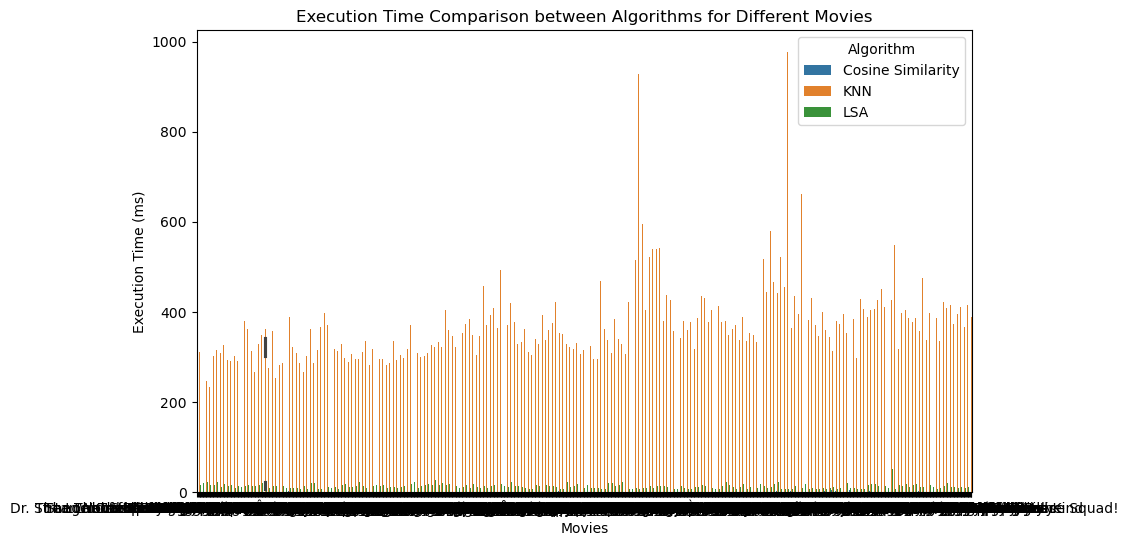

In [17]:
# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x="Movies", y="Execution Time", hue="Algorithm", data=data_melted)

# Add title and labels
plt.title("Execution Time Comparison between Algorithms for Different Movies")
plt.ylabel("Execution Time (ms)")
plt.xlabel("Movies")

plt.show()

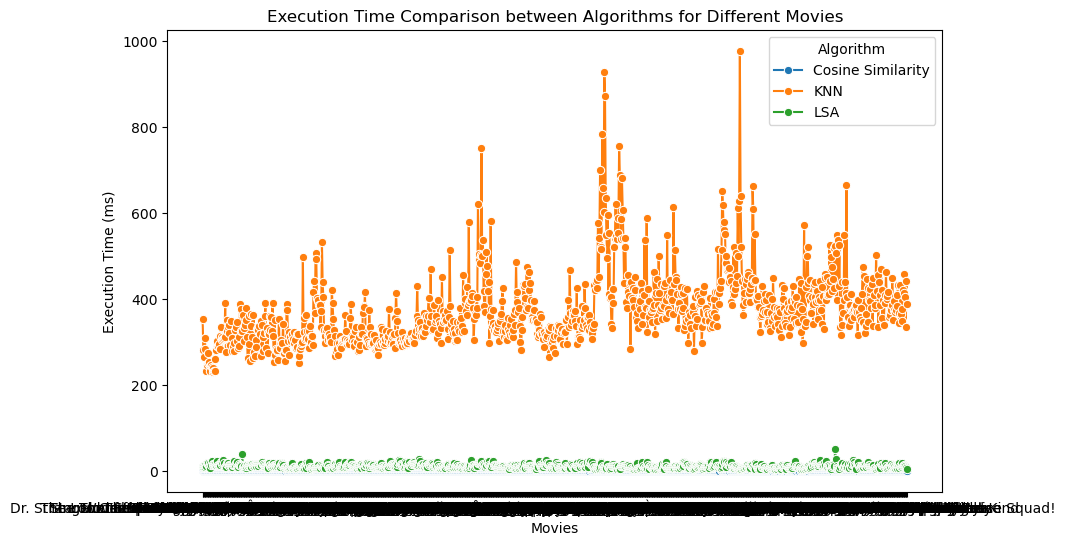

In [18]:
# Line Plot
plt.figure(figsize=(10, 6))
sns.lineplot(x="Movies", y="Execution Time", hue="Algorithm", data=data_melted, marker="o")

# Add title and labels
plt.title("Execution Time Comparison between Algorithms for Different Movies")
plt.ylabel("Execution Time (ms)")
plt.xlabel("Movies")

plt.show()

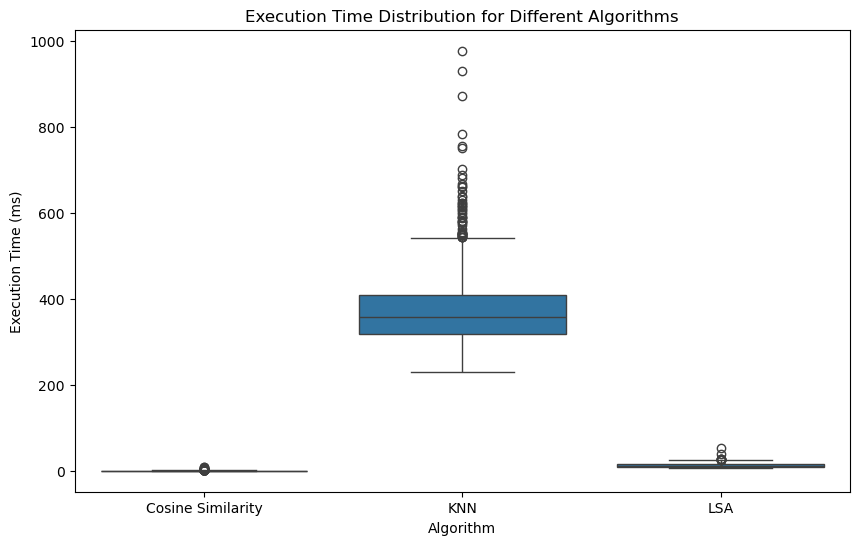

In [19]:
# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Algorithm', y='Execution Time', data=data_melted)

plt.title('Execution Time Distribution for Different Algorithms')
plt.ylabel('Execution Time (ms)')
plt.xlabel('Algorithm')

plt.show()

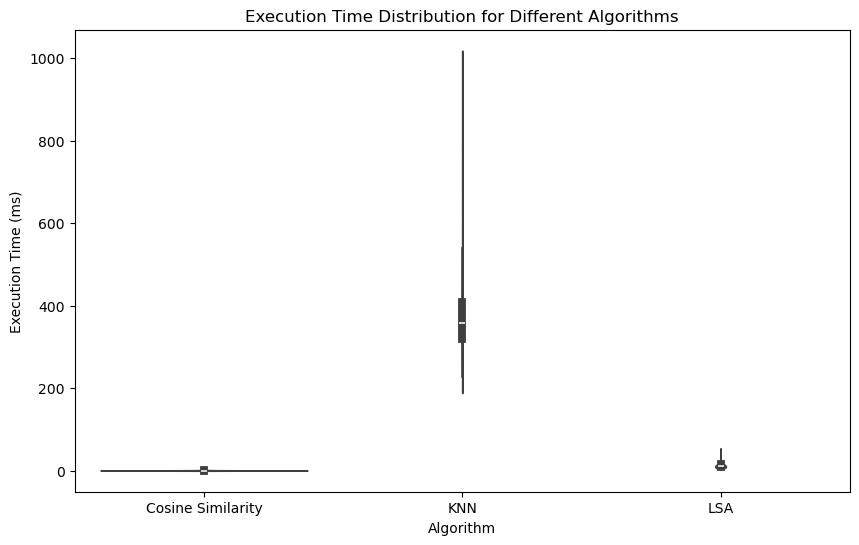

In [20]:
# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='Algorithm', y='Execution Time', data=data_melted)

plt.title('Execution Time Distribution for Different Algorithms')
plt.ylabel('Execution Time (ms)')
plt.xlabel('Algorithm')

plt.show()

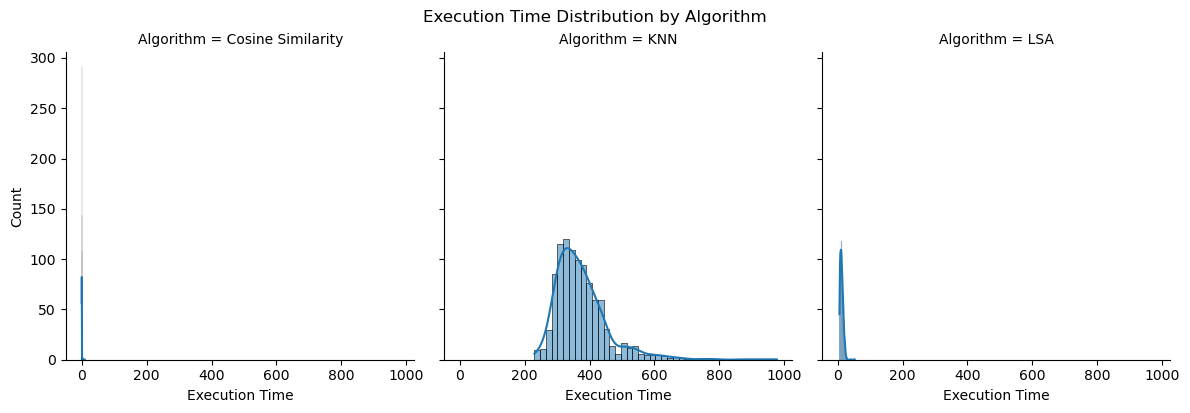

In [21]:
# FacetGrid of Histogram
g = sns.FacetGrid(data_melted, col="Algorithm", height=4, aspect=1)
g.map(sns.histplot, "Execution Time", kde=True)

# Add title
plt.suptitle('Execution Time Distribution by Algorithm', y=1.02)

# Show the plot
plt.show()